In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Project 2 Canny Edge Learner_Code_and_Images

/content/drive/MyDrive/Colab Notebooks/Project 2 Canny Edge Learner_Code_and_Images


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import signal
from PIL import Image
import argparse

# Copy the path of the folder that contains this notebook using the file navigation on the left:
# Ex. /content/drive/My\ Drive/CIS 581-Online/Canny Edge Project/Learner Code and Images/Code
print("Sys path", sys.path)
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Project 2 Canny Edge Learner_Code_and_Images/Code")
# import functions
from helpers import interp2

Sys path ['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


# Tests and Visualization

In [ ]:
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    if test_pass:
      print('Shape Test Passed! \n')
    else:
      print('Shape Test Failed! \n')

    return test_pass

In [ ]:
'''
  Derivatives visualzation function
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))
    Ori = np.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )
    


'''
  Edge detection result visualization function
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

# Functions

In [ ]:
'''
  Convert RGB image to gray one manually
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

In [ ]:
import math
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    # TODO: complete function
    G = np.array([[2, 4, 5, 4, 2], 
                          [4, 9, 12, 9, 4], 
                          [5, 12, 15, 12, 5], 
                          [4, 9, 12, 9, 4], 
                          [2, 4, 5, 4, 2]])
    #G = (1/159) * G 
    
    dx = np.array([[1, 0, -1], 
                   [2, 0, -2], 
                   [1, 0, -1]])
    
    dy = np.array([[1, 2, 1],
                  [0, 0, 0], 
                  [-1, -2, -1]])
      
   
    Gx = signal.convolve2d(G/159, dx, "same")
    Gy = signal.convolve2d(G/159, dy, "same")
    Magx = signal.convolve2d(I_gray, Gx, "same")
    Magy = signal.convolve2d(I_gray, Gy, "same")
    Mag = np.sqrt(Magx**2 + Magy**2)
    Ori = np.arctan2(Magy, Magx)
    
    return Mag,Magx,Magy,Ori

In [ ]:
## Test ##
import os
# you may need to change the path to I1.jpg under Images folder
I = plt.imread('/content/drive/MyDrive/Colab Notebooks/Project 2 Canny Edge Learner_Code_and_Images/Code/Images/I1.jpg')
os.chdir("/content/drive/MyDrive/Colab Notebooks/Project 2 Canny Edge Learner_Code_and_Images/Code") 
Mag, Magx, Magy, Ori = findDerivatives(I)

assert np.allclose(Mag, np.load('Mag.npy'))
assert np.allclose(Magx, np.load('Magx.npy'))
assert np.allclose(Magy, np.load('Magy.npy'))


assert np.allclose(Ori, np.load('Ori.npy'))

In [ ]:
def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the magnitude of derivatives
        - Input Ori: H x W matrix represents the orientation of derivatives
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    nr, nc = Mag.shape
    x,y = np.meshgrid(np.arange(nc), np.arange(nr))
    theta = Ori.copy()
    # # getting neighbor in the opposite of the orientation direction
    
    x_after, y_after = np.around(x+np.cos(theta), decimals=15), np.around(y+np.sin(theta), decimals=15)

    neigh1 = interp2(Mag, x_after, y_after)
    neigh1 = np.where((0 <= x_after) & (x_after <= nc-1) & (0 <= y_after) & (y_after <= nr-1), neigh1, 0)

    x_bfore, y_bfore = np.around(x-np.cos(theta), decimals=15), np.around(y-np.sin(theta), decimals=15)
    neigh2 = interp2(Mag, x_bfore, y_bfore)
    neigh2 = np.where((0<=x_bfore) & (x_bfore<=nc-1) & (0<=y_bfore) & (y_bfore<=nr-1), neigh2, 0)

    M = (Mag>=neigh1) & (Mag>=neigh2)
    return M

In [ ]:
## Test ##
Mag = np.array([[0, 2, 12, 16],
                [4, 9, 11, 8],
                [7, 17, 12, 9],
                [0, 19, 21, 17]])
Ori = np.array([[np.pi/2, np.pi/4, 0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4, 0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])
res = np.array([[False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [False,  True,  True,  True]])
M = nonMaxSup(Mag, Ori)
assert M.dtype == bool
assert M.shape == Mag.shape
assert np.allclose(M, res)

In [ ]:
import copy
from numpy import pi
def edgeLink(M, Mag, Ori, low, high):
    
    nr, nc = Mag.shape
    x,y = np.meshgrid(np.arange(nc), np.arange(nr))
    # getting neighbor in the edge direction
    theta = Ori[y,x]
    x_after, y_after = np.around(x-np.cos(theta+np.pi/2), decimals=10), np.around(y-np.sin(theta+pi/2), decimals=10)
    x_bfore, y_bfore = np.around(x+np.cos(theta+np.pi/2), decimals=10), np.around(y+np.sin(theta+pi/2), decimals=10)

    if(Mag.shape[0]<5):
      Mag = np.where(M, Mag, 0)
    count=0 
    while True:
      count+=1 
      Mag_old = Mag.copy()
      neigh1 = interp2(Mag, x_after, y_after) 
      neigh1 = np.where((0<=x_after) & (x_after<=nc-1), neigh1, 0)
      neigh1 = np.where((0<=y_after) & (y_after<=nr-1), neigh1, 0)
      neigh2 = interp2(Mag, x_bfore, y_bfore) 
      neigh2 = np.where((0<=x_bfore) & (x_bfore<=nc-1), neigh2, 0)  
      neigh2 = np.where((0<=y_bfore) & (y_bfore<=nr-1), neigh2, 0) 
      Mag = np.where((Mag<high) & (Mag>low) & (np.maximum(neigh1, neigh2) > high), np.maximum(neigh1, neigh2), Mag)
      if(np.array_equal(Mag_old, Mag) or count>50):
        break
        
    return (Mag>high) & (M)

In [ ]:
## Test ##
M = np.array([[True, False, True,  True],
              [False, True,  True, True],
              [True,  True, False, False],
              [False,  True,  True,  True]])
Mag = np.array([[12, 9, 14, 16],
                [4, 11, 40, 18],
                [13, 12, 30, 15],
                [28, 15, 21, 8]])
Ori = np.array([[np.pi/2, np.pi/4, 0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4, 0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])
res = np.array([[False, False,  True,  True],
       [False,  True,  True,  True],
       [ True,  True, False, False],
       [False, False,  True, False]])
low, high = 10, 20
E = edgeLink(M, Mag, Ori, low, high)
print(E)
assert E.dtype == bool
assert E.shape == Mag.shape
assert np.allclose(E, res)

[[False False  True  True]
 [False  True  True  True]
 [ True  True False False]
 [False False  True False]]


In [ ]:
def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)

    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)

    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)

        plt.show()

    return E

## Simple image test cases
First, let's try to detect edges in two simple images.

![checkerboard.jpg](Test_Images/rotated_checkerboard.jpg)

For the rotated checkerboard, We should be able to get edges in both directions.

![checkerboard_res.jpg](Test_Images/rotated_checkerboard_Result.png)

![coins.png](Test_Images/coins.png) 

For coins, we should be able to detect circles.

![coins.png](Test_Images/coins_Result.png) 

Shape Test Passed! 



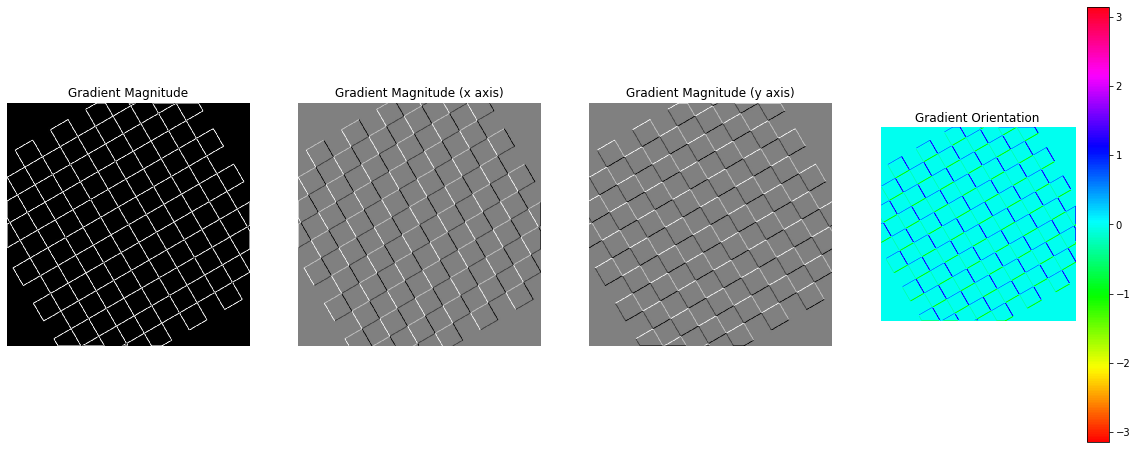

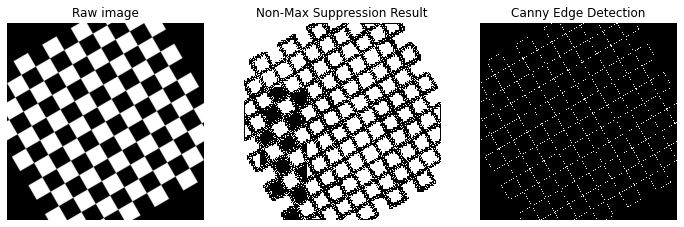

In [ ]:
# tuning threshold for simple test images
image_folder = "Test_Images"
save_folder = "Results" # need to create this folder in the drive
filename='rotated_checkerboard.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 20, 60 
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

## Tune the threshold for each images under "Image" folder

In [ ]:
 # list all image names
 os.listdir('Images')

['189080.jpg',
 '16068.jpg',
 '3096.jpg',
 '86000.jpg',
 '22013.jpg',
 '118035.jpg',
 '48017.jpg',
 '21077.jpg',
 'I1.jpg',
 '55067.jpg',
 '135069.jpg',
 '201080.jpg']

Shape Test Passed! 



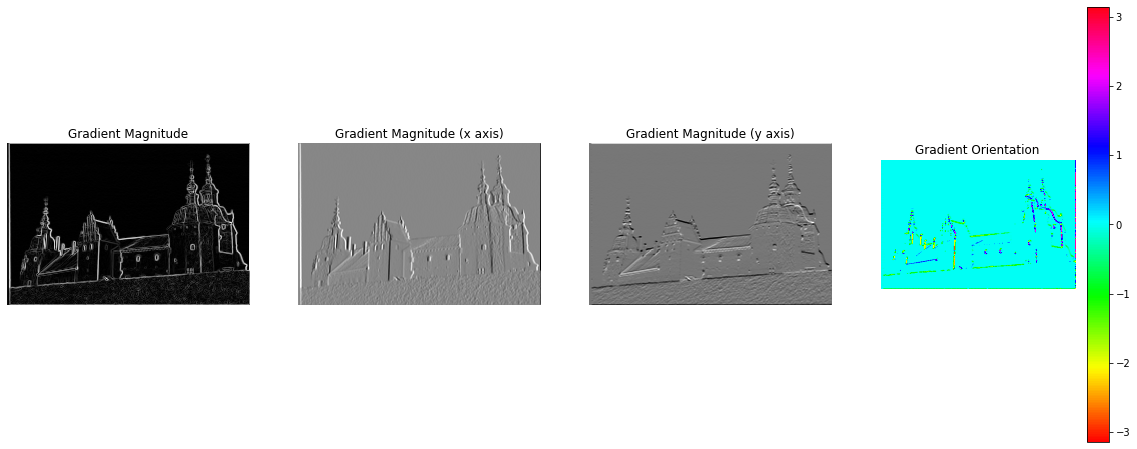

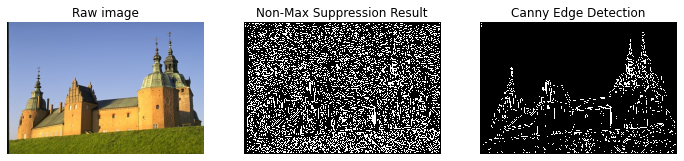

In [ ]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='201080.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 20, 45
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

# Fill in all tuned threshold to generate edge detection results


G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 7.84615180e-01  1.19068868e+00  1.56429870e+00 ...  1.57483721e+00
   1.94829352e+00  2.35518093e+00]
 [ 3.76301334e-01  7.80732297e-01  1.55579478e+00 ...  1.57888713e+00
   2.35647541e+00  2.76371284e+00]
 [-6.85402593e-04 -1.94459079e-03 -1.81521259e-01 ... -2.60732314e+00
  -3.13886560e+00 -3.14073528e+00]
 ...
 [-6.50769139e-01 -1.03076249e+00 -1.45202689e+00 ... -1.59537383e+00
  -2.54638187e+00 -2.88764653e+00]
 [-4.35296471e-01 -8.23643080e-01 -1.52542039e+00 ... -1.47516461e+00
  -2.24663888e+00 -2.65395176e+00]
 [-8.24060147e-01 -1.18945061e+00 -1.55369215e+00 ... -1.57069746e+00
  -1.96693935e+00 -2.34

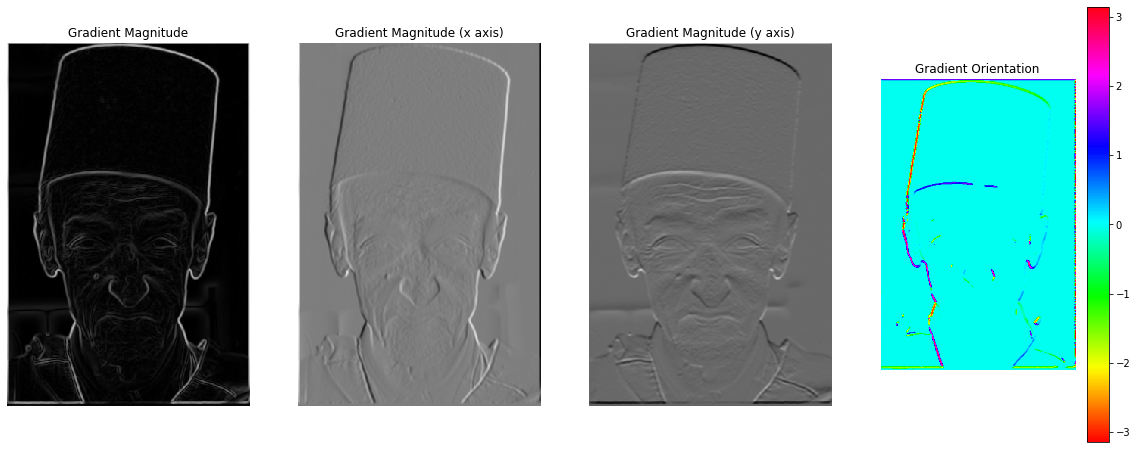

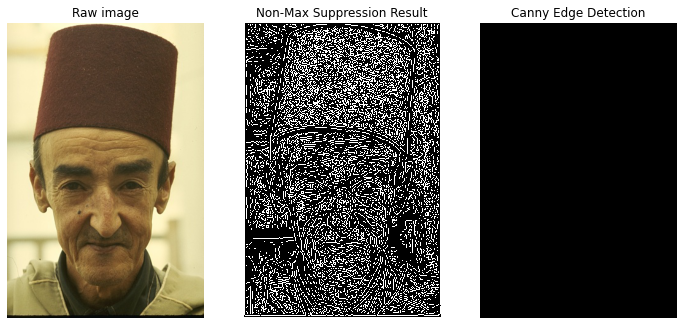

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 0.7416722   1.1009565   1.45638139 ...  1.91620048  2.23060328
   2.4431046 ]
 [ 0.34341854  0.65077069  1.28604505 ...  2.08207739  2.46707597
   2.63996583]
 [-0.0252249  -0.07889478 -0.43963149 ...  2.57316322  2.7986339
   2.85214113]
 ...
 [-0.01161424 -0.0428707  -0.28661248 ... -2.50861372 -2.7814288
  -2.85797104]
 [-0.37251326 -0.73783084 -1.35763605 ... -2.10409886 -2.46530766
  -2.64082848]
 [-0.77835594 -1.16090833 -1.49417069 ... -1.94739215 -2.23982171
  -2.44063439]]
QWE [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.853

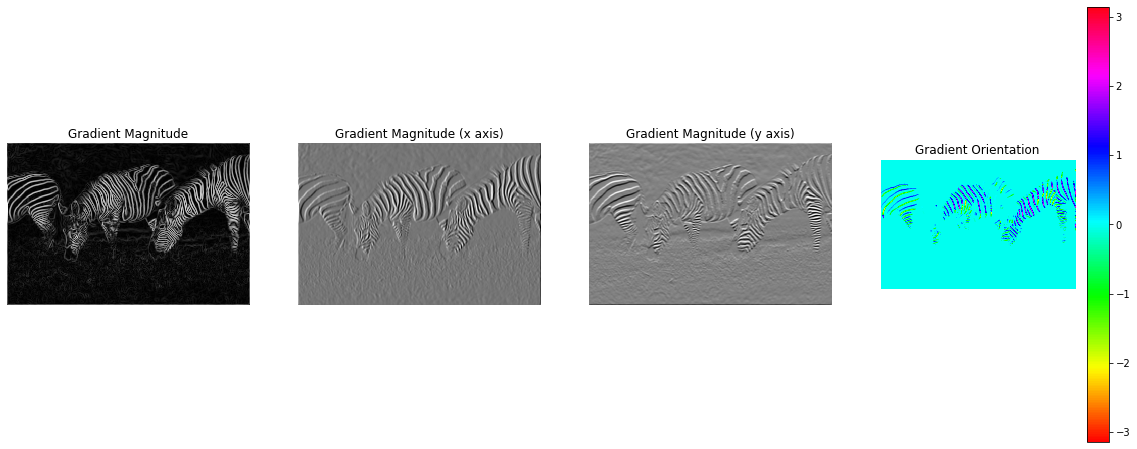

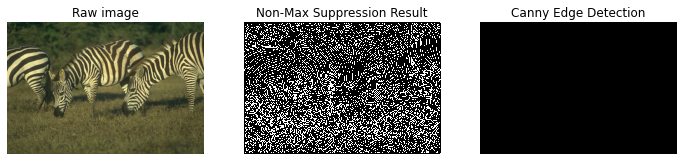

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 7.75693889e-01  1.18880135e+00  1.57306237e+00 ...  1.58753101e+00
   1.97177650e+00  2.36274356e+00]
 [ 3.68906465e-01  7.73697111e-01  1.57118491e+00 ...  1.58342024e+00
   2.35871963e+00  2.74522443e+00]
 [-2.57305114e-03 -9.12532820e-03 -1.63453326e+00 ...  1.13751788e+00
   3.09655042e+00  3.11069239e+00]
 ...
 [-3.25387027e-01 -5.07892378e-01 -1.06309531e+00 ... -1.71054092e+00
  -3.00670617e+00 -3.05986813e+00]
 [-6.64800244e-01 -9.20362137e-01 -1.25641165e+00 ... -1.63865727e+00
  -2.32732250e+00 -2.69660209e+00]
 [-8.92902531e-01 -1.09572549e+00 -1.30176635e+00 ... -1.62951234e+00
  -1.98911782e+00 -2.34

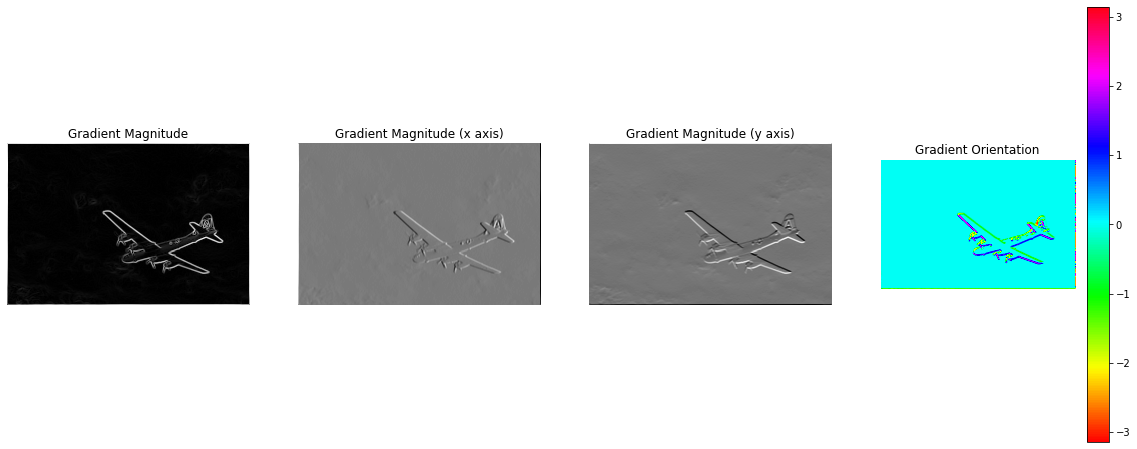

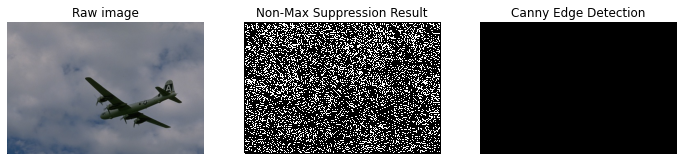

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 0.7862423   1.20476976  1.57824471 ...  1.68190312  1.9073198
   2.19944957]
 [ 0.37363753  0.79609293  1.50153701 ...  1.7092738   2.09374322
   2.45909845]
 [ 0.01220893  0.13185358  0.89635185 ...  1.78029478  2.49745726
   2.80491225]
 ...
 [ 0.03963563  0.11570189  2.74050246 ...  1.88057426  3.04928623
   3.0891464 ]
 [-0.3933629  -0.91103702 -1.80718499 ... -1.56147973 -2.34425043
  -2.76438153]
 [-0.82826507 -1.282832   -1.67248136 ... -1.56458545 -1.93773612
  -2.34965536]]
QWE [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.85

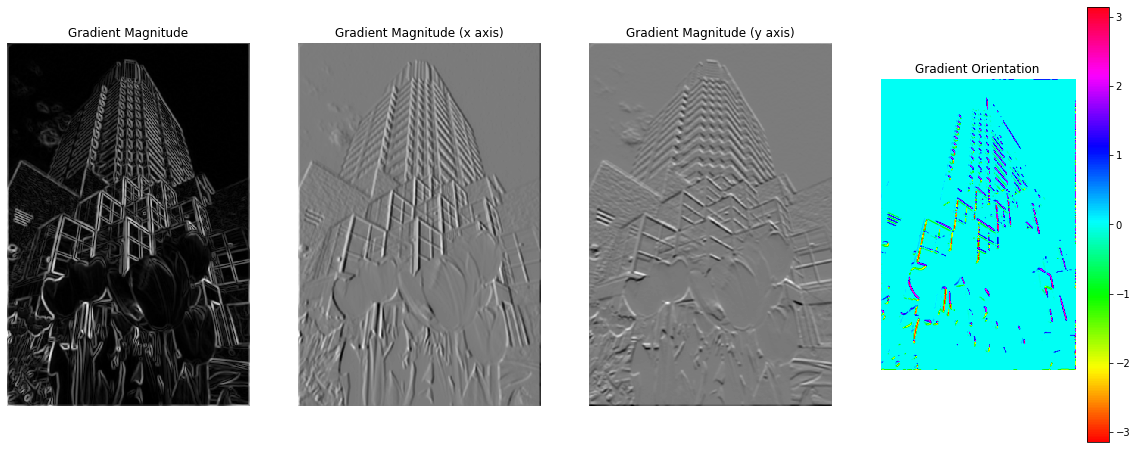

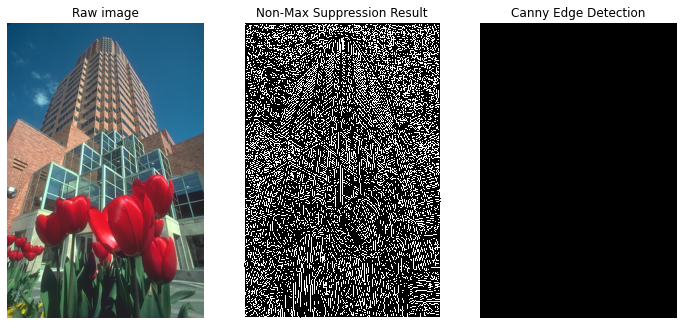

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 0.78626639  1.19524769  1.56953863 ...  1.56253457  1.93701604
   2.34656855]
 [ 0.37515482  0.78370827  1.56665688 ...  1.5433167   2.32267586
   2.7459556 ]
 [-0.00368221 -0.00930014 -0.9604024  ...  0.96585625  3.08262137
   3.11831435]
 ...
 [-1.00833375 -1.27475042 -1.49485104 ... -2.27771251 -3.07970796
  -3.12679992]
 [-0.93133713 -1.21817284 -1.4495049  ... -1.61750182 -2.37007212
  -2.77044687]
 [-0.85290483 -1.21892817 -1.51733471 ... -1.58256802 -1.95300779
  -2.35747614]]
QWE [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.8

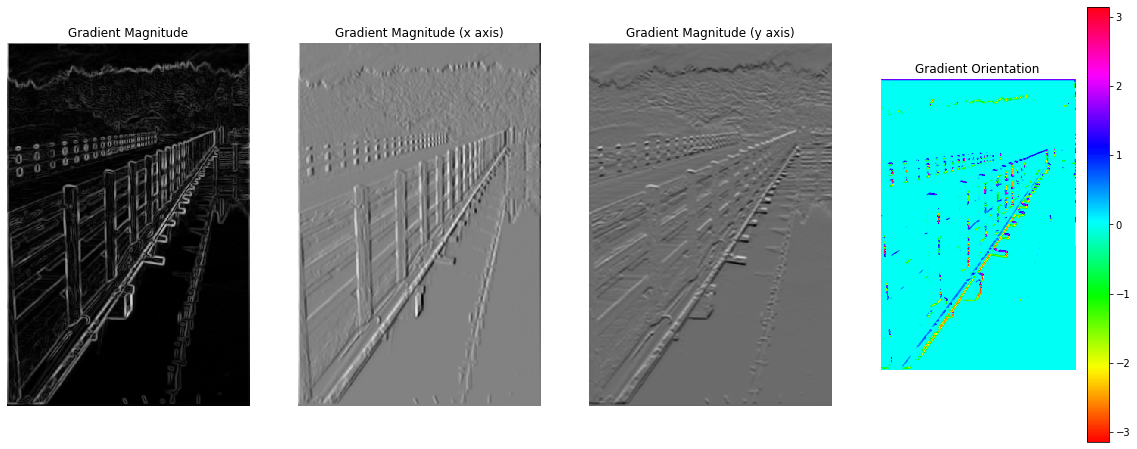

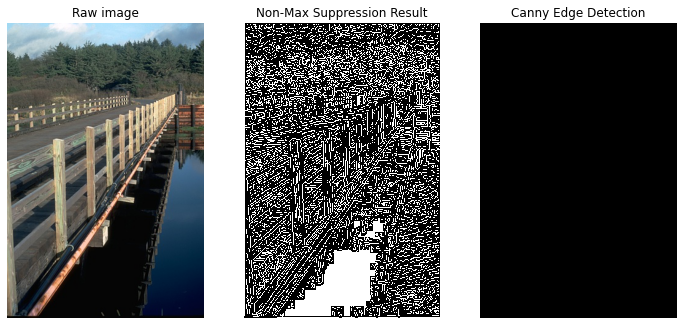

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 7.91624307e-01  1.19817896e+00  1.57079633e+00 ...  1.58117371e+00
   1.95504195e+00  2.35863729e+00]
 [ 3.90857400e-01  8.05586451e-01  1.57079633e+00 ...  1.60179863e+00
   2.36150951e+00  2.76281442e+00]
 [ 1.64153096e-02  4.14052085e-02  1.57079633e+00 ...  2.56480394e+00
   3.12283907e+00  3.13583972e+00]
 ...
 [ 1.43349287e-16  1.76531993e-16  9.82793723e-01 ... -3.01054939e+00
  -3.13913607e+00  3.14116370e+00]
 [-3.76832624e-01 -7.85398163e-01 -1.57079633e+00 ... -1.61720075e+00
  -2.38878437e+00 -2.77376430e+00]
 [-7.85398163e-01 -1.19396370e+00 -1.57079633e+00 ... -1.58685969e+00
  -1.96937207e+00 -2.36

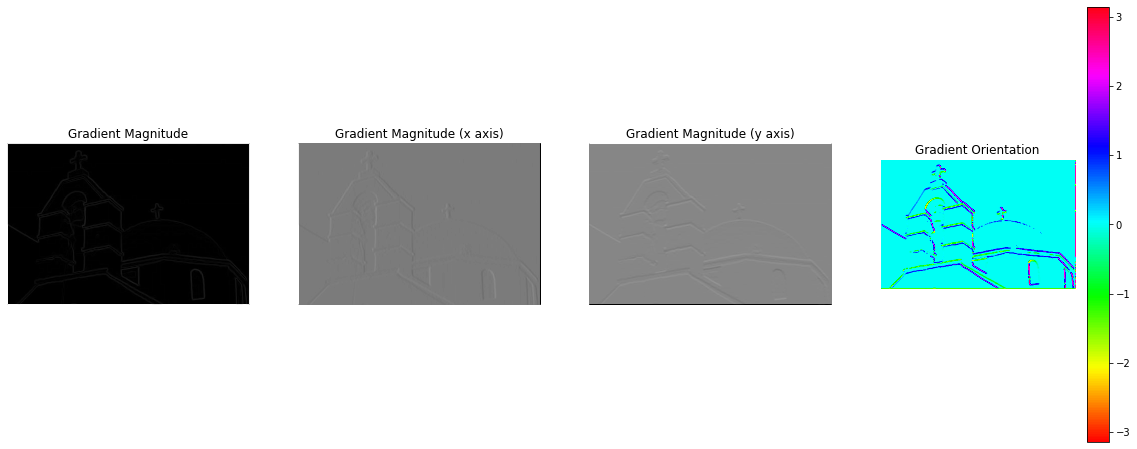

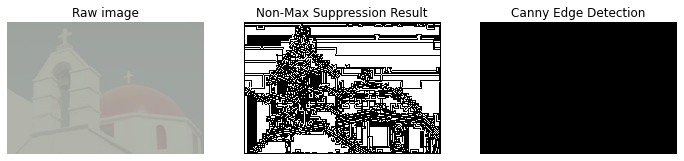

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 7.96267492e-01  1.19194062e+00  1.54286800e+00 ...  1.76574603e+00
   2.00128785e+00  2.30113272e+00]
 [ 3.82533655e-01  7.87961104e-01  1.19681667e+00 ...  1.75596363e+00
   2.01394589e+00  2.30680611e+00]
 [ 2.92068576e-02  3.45637450e-01  7.56611493e-01 ...  1.65647829e+00
   1.96495775e+00  2.29008048e+00]
 ...
 [-4.70367362e-17 -1.73774609e-16  7.85398163e-01 ... -9.57783970e-02
  -3.12002348e+00 -3.13816788e+00]
 [-3.76832624e-01 -7.85398163e-01 -1.57079633e+00 ... -9.93352712e-01
  -2.35754247e+00 -2.82822740e+00]
 [-7.85398163e-01 -1.19396370e+00 -1.57079633e+00 ... -1.30617974e+00
  -1.93962940e+00 -2.44

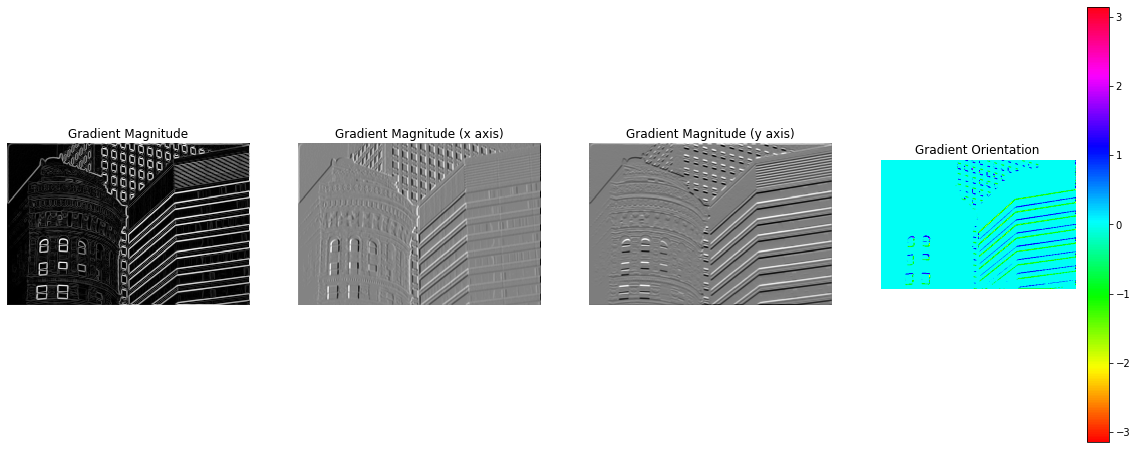

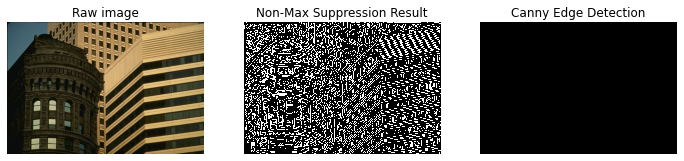

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 0.79391041  1.19970498  1.56552215 ...  1.58203358  1.94159976
   2.34685654]
 [ 0.38840798  0.8038707   1.56335017 ...  1.58927267  2.32826072
   2.74679395]
 [ 0.01142234  0.02889091  1.53487662 ...  1.75677813  3.08384683
   3.12066626]
 ...
 [ 0.02223236  0.10199945  1.33183179 ...  1.43790264  3.0794041
  -3.14135536]
 [-0.27388721 -0.51278842 -1.30440835 ... -1.61288703 -2.35479161
  -2.73562538]
 [-0.68572723 -1.05175348 -1.47885517 ... -1.6132464  -1.96701309
  -2.34374966]]
QWE [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.85

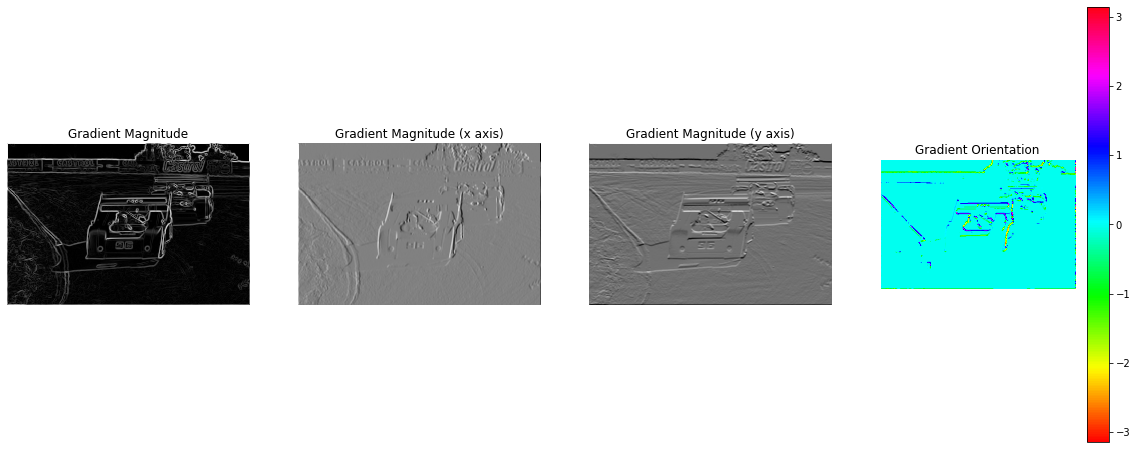

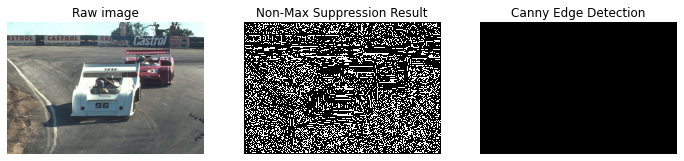

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.85398163e-01  1.57079633e+00 ...  1.57079633e+00
   2.35619449e+00  2.76476003e+00]
 [ 5.26568665e-17  9.72689340e-17  1.57079633e+00 ...  2.03444394e+00
  -3.14159265e+00  3.14159265e+00]
 ...
 [ 3.33149326e-17  9.23101256e-17  1.50422816e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.76832624e-01 -7.85398163e-01 -1.57079633e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.85398163e-01 -1.19396370e+00 -1.57079633e+00 ...  0.00000000e+00
   0.00000000e+00  0.00

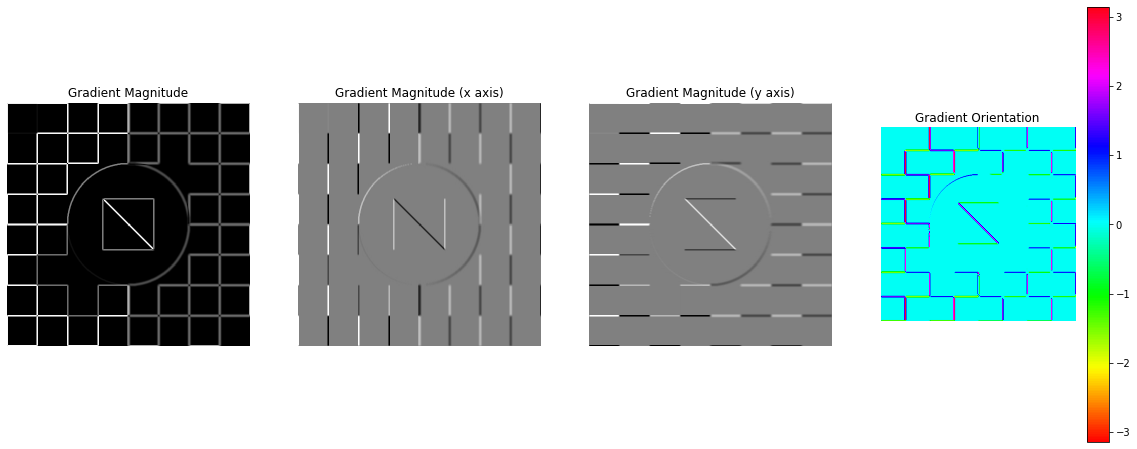

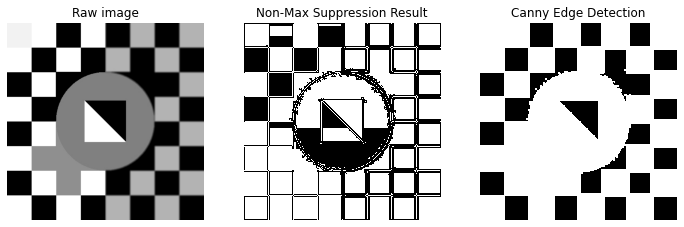

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 0.78249055  1.18853545  1.56265223 ...  1.56313895  1.94641027
   2.3597517 ]
 [ 0.3792976   0.7833568   1.54873374 ...  1.55660014  2.35657389
   2.76747072]
 [ 0.01039415  0.02298289  0.78163613 ... -0.47507452 -3.13301607
  -3.1377593 ]
 ...
 [-0.05246403  0.13559257  0.78667619 ... -0.25217942 -3.13650822
  -3.14103756]
 [-0.28065086 -0.37146218 -0.78572165 ... -1.52014546 -2.31748819
  -2.74524499]
 [-0.61129014 -0.88165578 -1.29895593 ... -1.55094323 -1.92893886
  -2.33585422]]
QWE [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.8

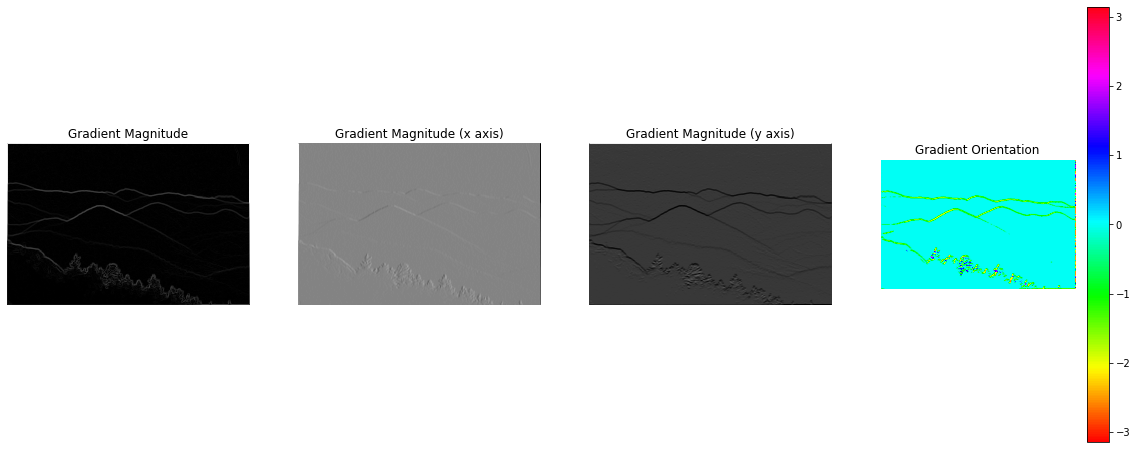

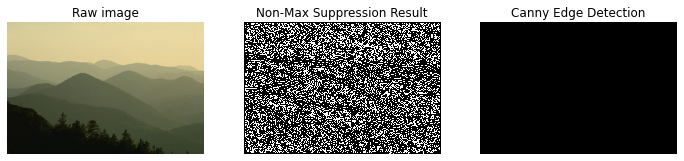

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 0.74709447  0.95086697  1.15685875 ...  1.58208635  1.94802574
   2.35658821]
 [ 0.39932074  0.5965197   0.8674887  ...  1.60668341  2.36232172
   2.76898801]
 [ 0.13009811  0.23161675  0.39040782 ...  2.58571642  3.12104022
   3.13709109]
 ...
 [ 0.00675511  0.01361355  2.93256328 ...  3.09575218  3.14060785
   3.14068953]
 [-0.38172451 -0.80460801 -1.60845592 ... -1.58566281 -2.36224493
  -2.767749  ]
 [-0.79284775 -1.20717576 -1.58681066 ... -1.57716099 -1.95035144
  -2.3582824 ]]
QWE [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.8

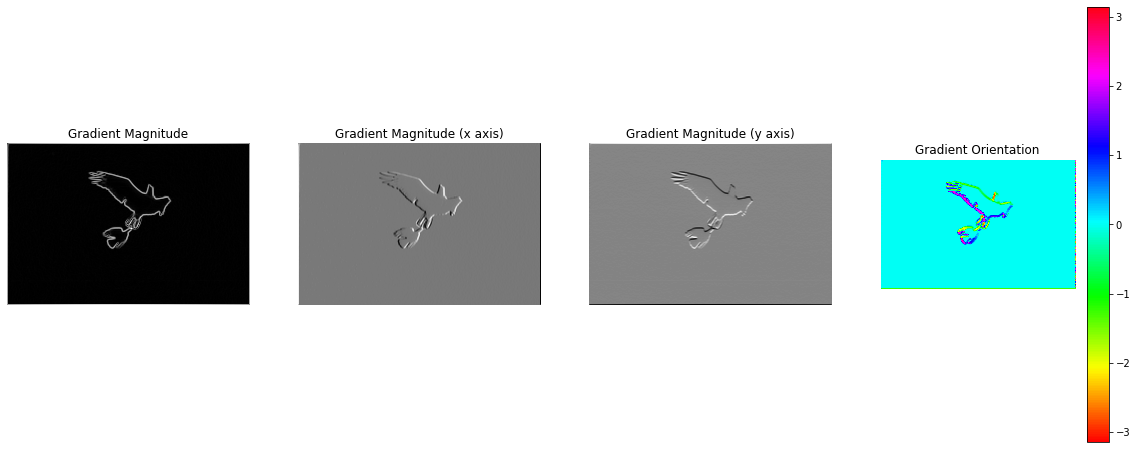

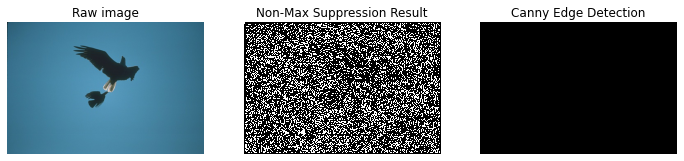

G [[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
Dx [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Dy [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
Ori [[ 0.73958643  0.86863829  0.55333474 ...  1.5670749   1.94269096
   2.35222478]
 [ 0.40349494  0.47158772  0.23544362 ...  1.56302174  2.34537444
   2.76008113]
 [ 0.06900362  0.00570598 -0.01994034 ...  1.3980421   3.12045224
   3.13538577]
 ...
 [-0.01192179 -0.02776818 -2.93541571 ... -1.81784647 -2.81418852
  -2.9759692 ]
 [-0.34038947 -0.84921777 -1.81349446 ... -1.64213427 -2.18490988
  -2.57599659]
 [-0.77421693 -1.26937513 -1.68401224 ... -1.60619816 -1.90662313
  -2.23281601]]
QWE [[ 7.85398163e-01  1.19396370e+00  1.57079633e+00 ...  1.57079633e+00
   1.94762895e+00  2.35619449e+00]
 [ 3.76832624e-01  7.8

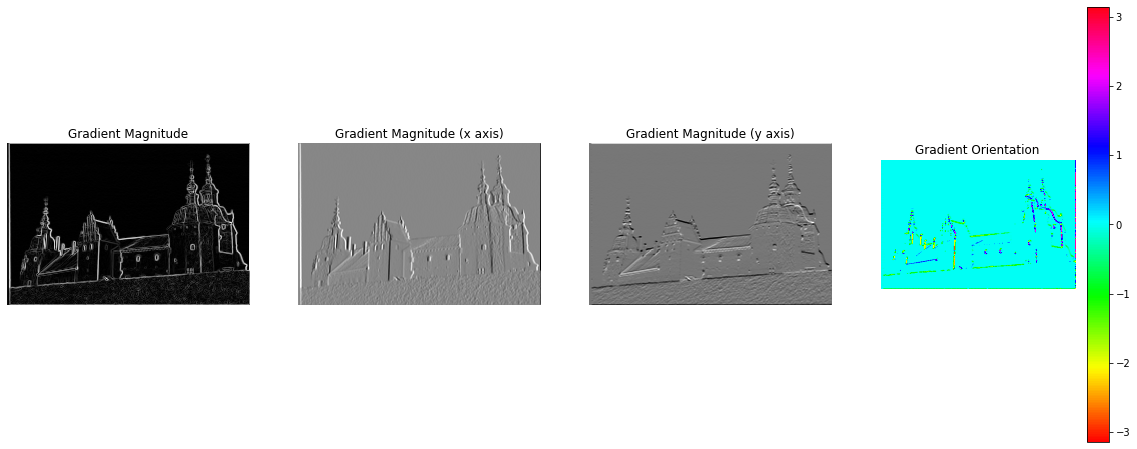

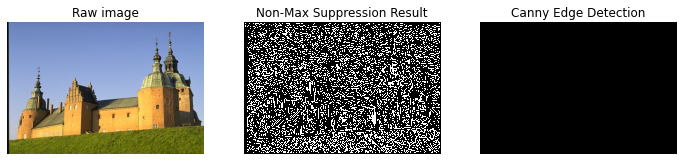

In [ ]:
# keep results for all images
image_folder = "Images"
save_folder = "Results"
# fill in the threshold (low, high) you have tuned in the cell above 
thresh_dict = {'118035.jpg': (0, 0),
                '135069.jpg': (0, 0),
                '16068.jpg': (0, 0),
                '189080.jpg': (0, 0),
                '201080.jpg': (0, 0),
                '21077.jpg': (0, 0),
                '22013.jpg': (0, 0),
                '3096.jpg': (0, 0),
                '48017.jpg': (0, 0),
                '55067.jpg': (0, 0),
                '86000.jpg': (0, 0),
                'I1.jpg': (0, 0)}
# generate results one by one
for filename in os.listdir(image_folder):
    # read in image 
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))

    low, high = thresh_dict[filename]
    E = cannyEdge(I, low, high)

    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')

    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))